In [ ]:
# colab 사용 시! Local PC로 실습하는 경우 실행 x / 단, 작업경로를 2025_LGE_SSL로 맞춰주기

!git clone https://github.com/Im-JihyunKim/2025_LG_ES_SSL.git
%cd /content/2025_LG_ES_SSL

In [1]:
# !pip install IPython
from IPython.display import Image

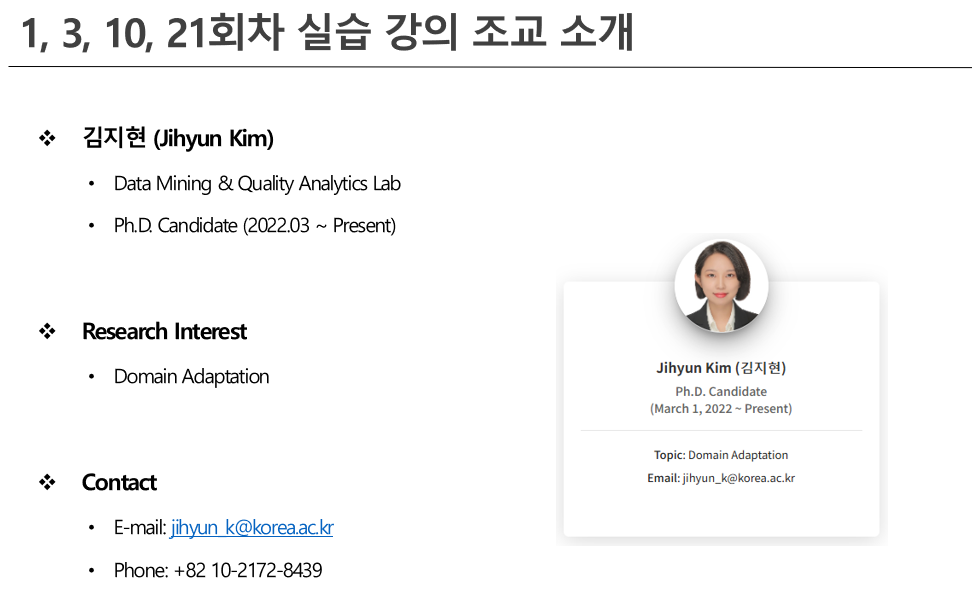

In [2]:
Image('./images/img0.png')

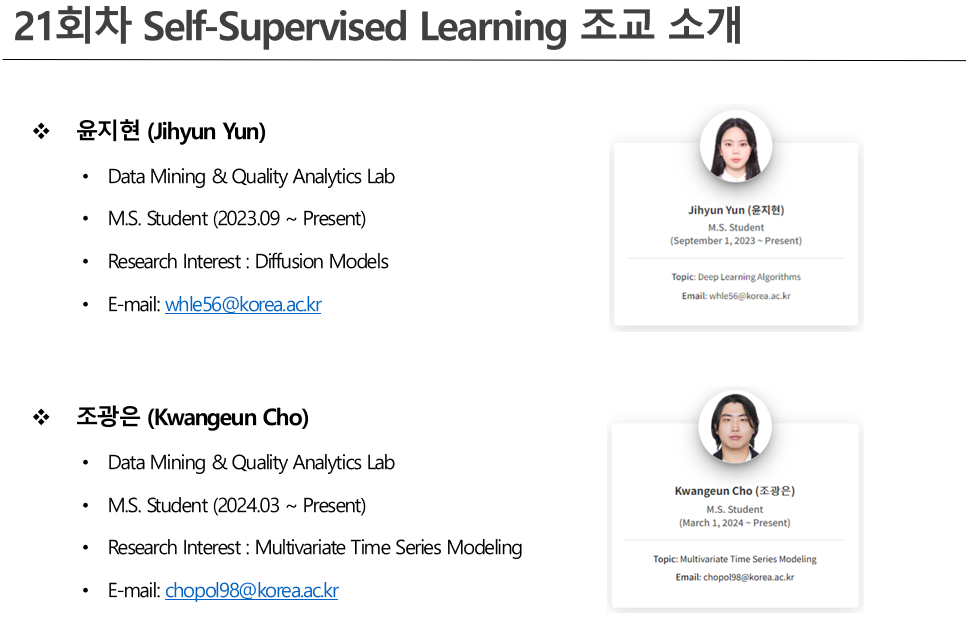

In [2]:
Image('./images/assist.png')

------

## Task: Self-supervised Learning - Pretext Task
### AutoEncoder

#### Jupyter Notebook 단축키

- ctrl+enter: 셀 실행   
- shift+enter: 셀 실행 및 다음 셀 이동   
- alt+enter: 셀 실행, 다음 셀 이동, 새로운 셀 생성
- a: 상단에 새로운 셀 만들기
- b: 하단에 새로운 셀 만들기
- dd: 셀 삭제(x: 셀 삭제)

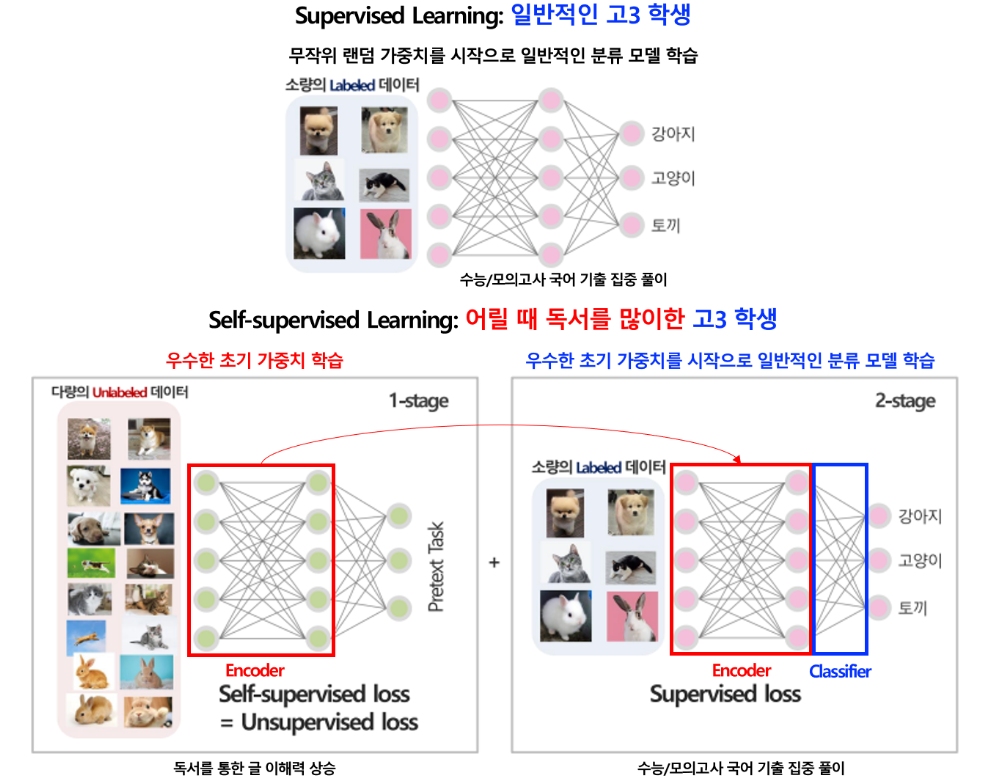

In [3]:
Image('images/2-SelfsupervisedLearning1.PNG')

## AutoEncoder
- Pretraining Task
- Downstream Task
- 실험 결과 비교

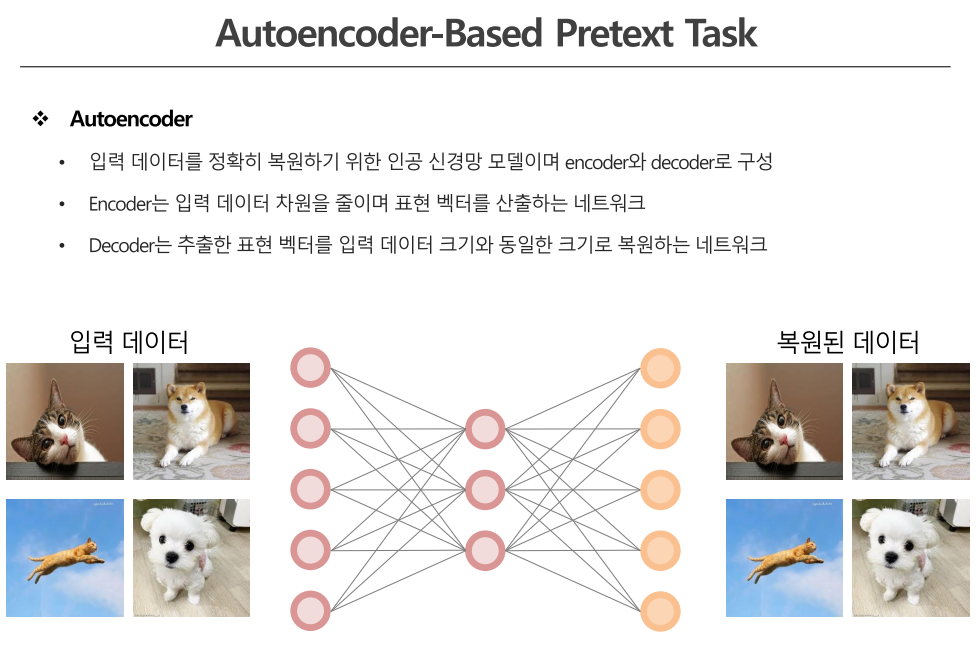

In [3]:
Image('images/5-AutoEncoder.PNG')

## 1. 필요 모듈(라이브러리) 호출

In [5]:
import os, random
import numpy as np

import torch
import torch.nn as nn

from torch.utils.data import Dataset, DataLoader, Subset  # 미니배치 학습, 데이터 셔플, 병렬 처리까지 간단하게 수행 가능하도록 지원
from torchvision.transforms import transforms
from torchvision import transforms, datasets
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
plt.set_cmap('cividis')

import warnings
warnings.filterwarnings(action='ignore')

<Figure size 640x480 with 0 Axes>

## 2. 학습 전 준비

### GPU 확인 및 사용할 device 설정

In [6]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

### Seed/Random state 고정

In [7]:
# 똑같은 결과를 얻기 위한 시드 고정
def set_seed(seed:int=0):
    torch.manual_seed(seed) # torch cpu seed 고정
    torch.cuda.manual_seed(seed) # torch gpu seed 고정
    torch.cuda.manual_seed_all(seed) # torch multi-gpu seed 고정
    # CUDA randomness
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

    np.random.seed(seed) # numpy seed 고정
    random.seed(seed)    # python seed 고정
    os.environ['PYTHONHASHSEED'] = str(seed)

In [8]:
set_seed()  # 0으로 자동 설정
# set_seed(seed=0)

## 3. Custom Dataset 정의
- 방대한 데이터를 batch 단위로 쪼개서 불러올 수 있도록 정의해주는 과정 (기존에는 모든 데이터셋을 한꺼번에 처리)
- Custom Dataset은 가변 길이 input이나 batch를 만들어줄 때 필요  
cf. https://didu-story.tistory.com/85

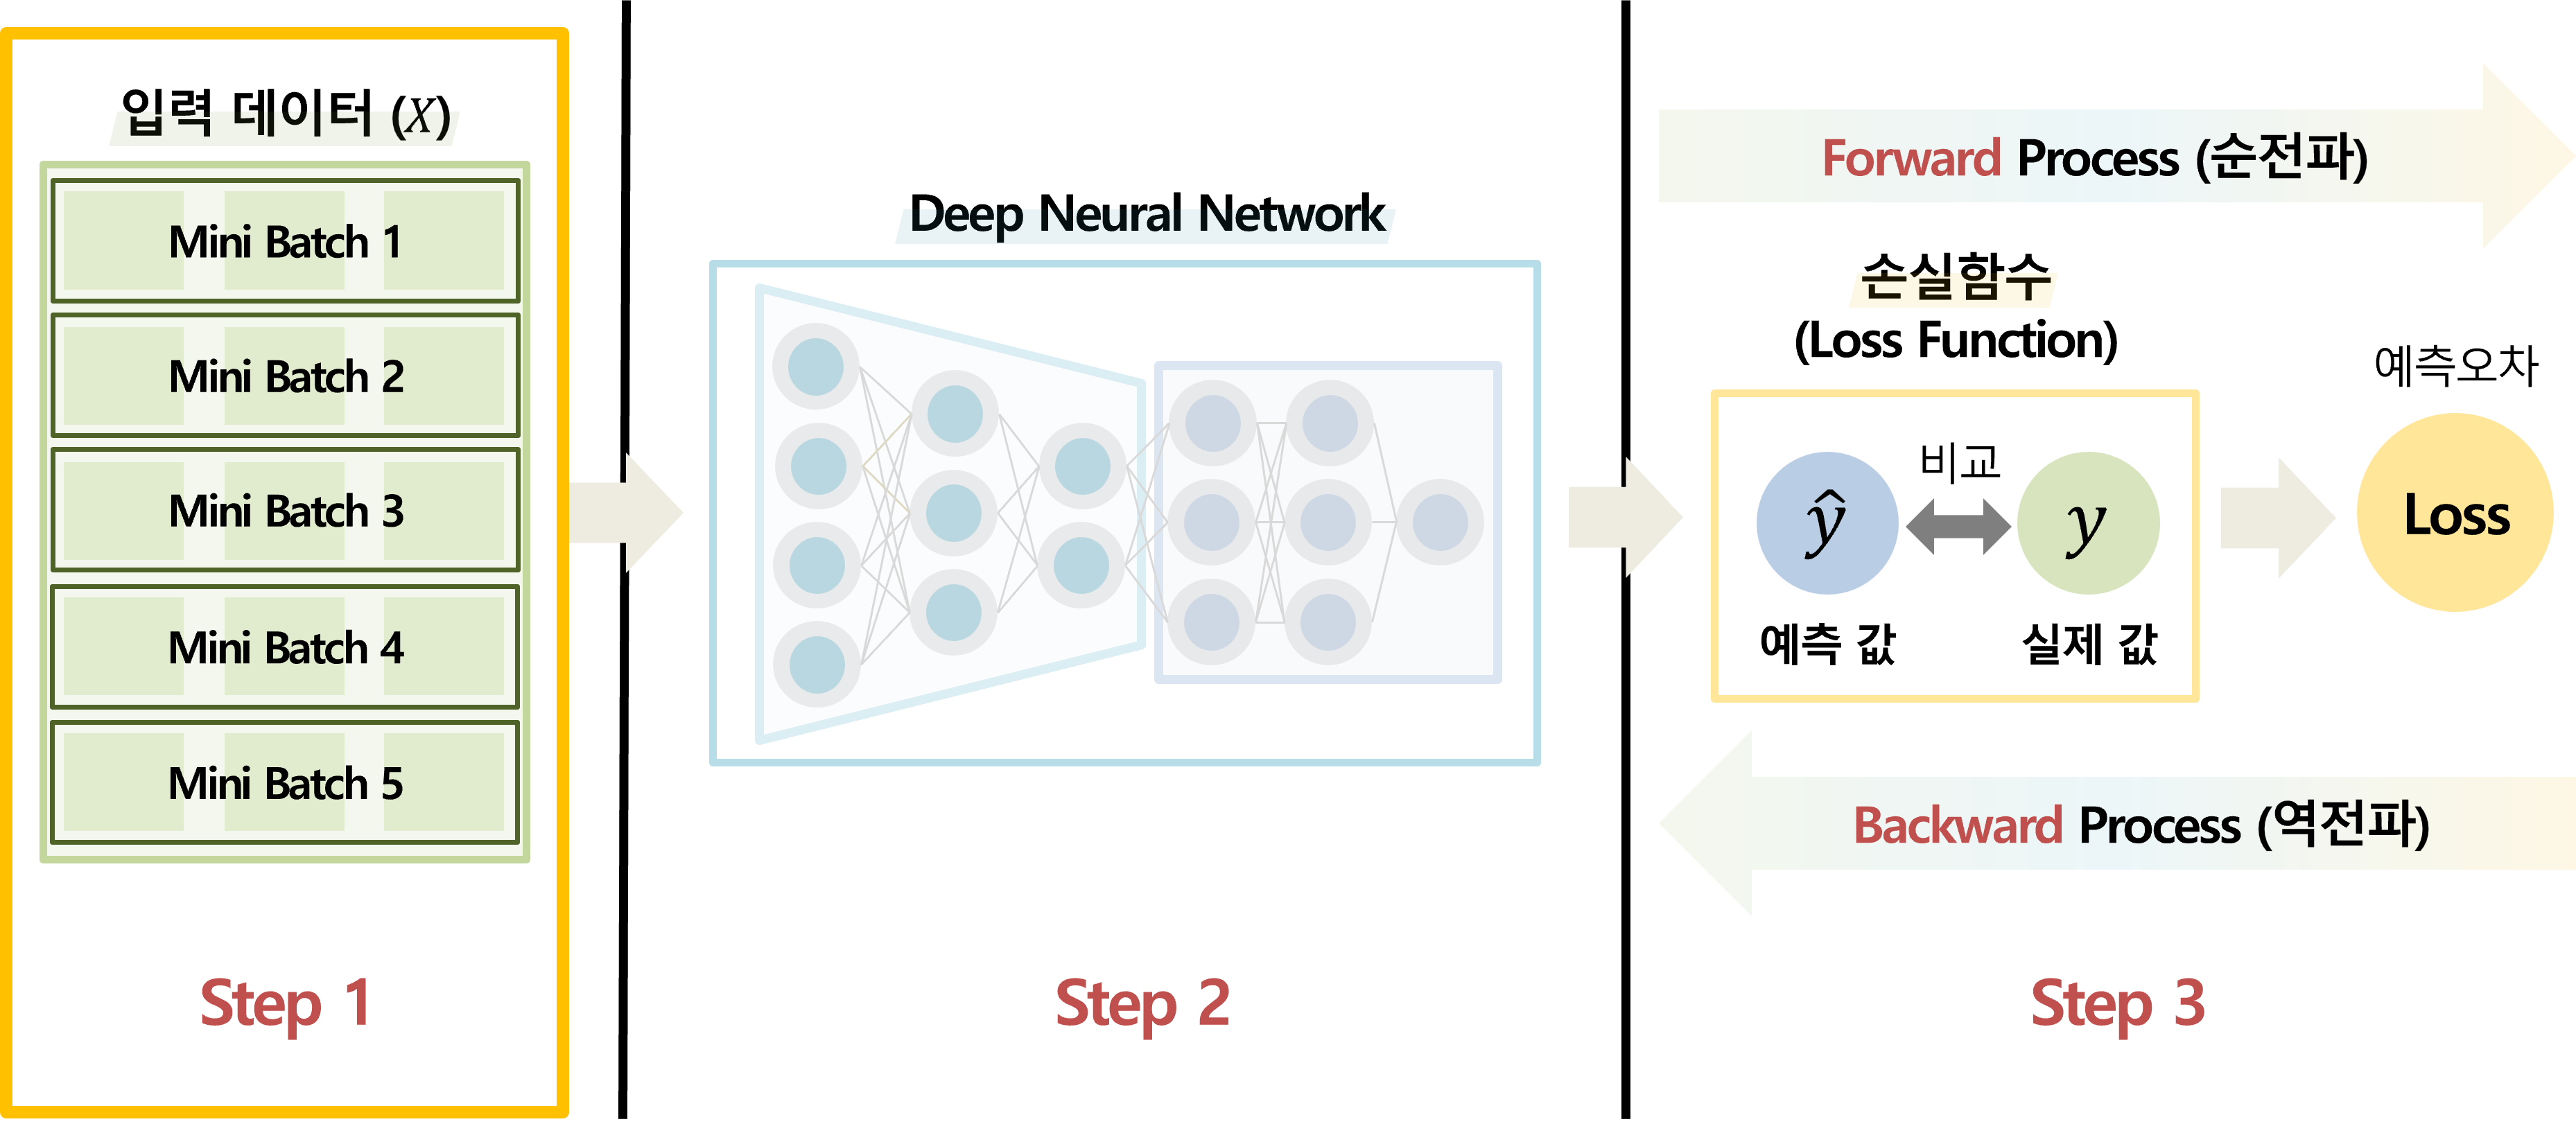

In [4]:
Image('images/step1.png')

### Fashion MNIST Dataset

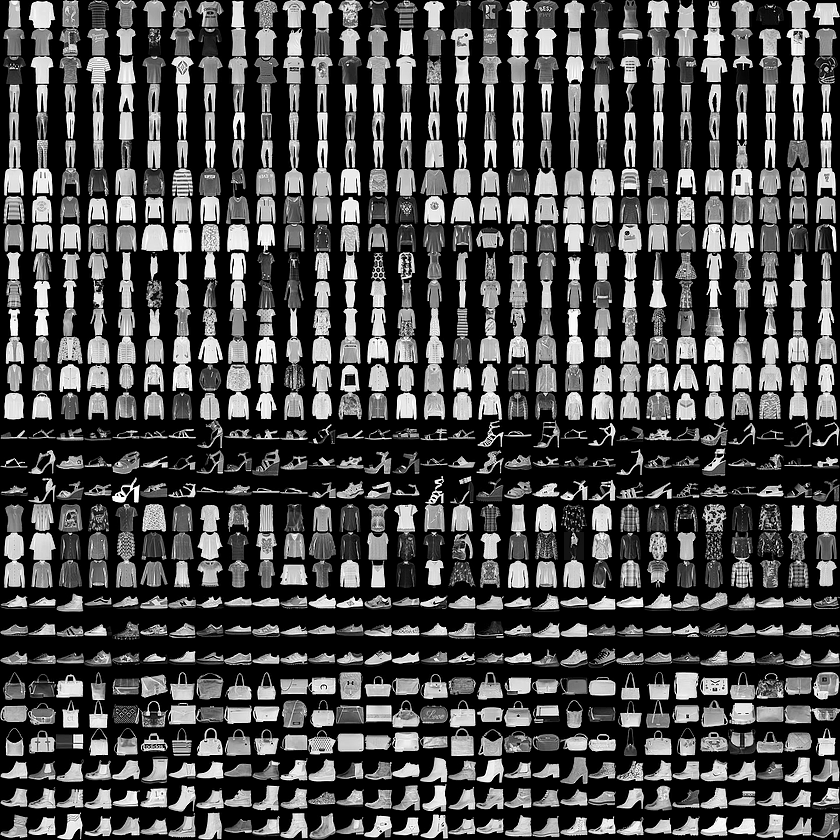

In [9]:
Image('images/3-FashionMNIST1.PNG')

- 28x28의 흑백 이미지로 구성된 데이터셋
  - 총 70,000개의 데이터가 있으며 일반적으로 60,000개는 학습용, 10,000개는 테스트용으로 구분해서 사용
  - 본 튜토리얼에서는 60,000개의 학습용 이미지를 Pretraining Task에서, 10,000개의 테스트용 이미지를 Downstream Task에 활용
    - 10,000개의 Downstream Task용 이미지는 8,000개의 Train과 2,000개의 Test 데이터로 구분됨 (Validation Dataset은 따로 지정하지 않음)
- 10개의 class를 분류하는 image classification task

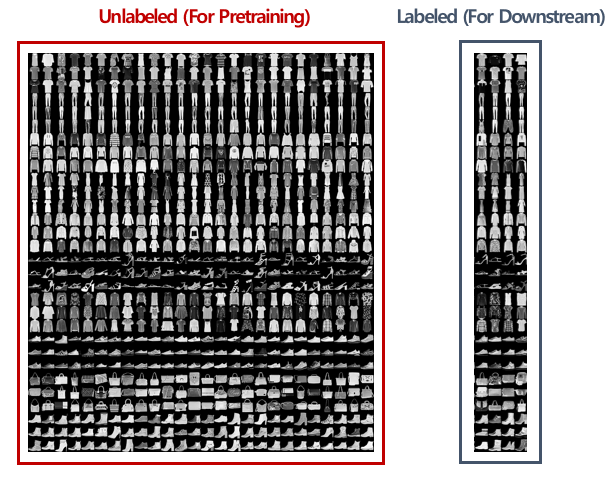

In [11]:
Image('images/3-FashionMNIST2.PNG')

In [10]:
# Custom Dataset
class FashionMNISTDataset(Dataset):
    
    ### 데이터셋 경로 정의
    def __init__(self, data_dir:str):
        self.data_dir = data_dir
        # 저장 경로 폴더가 없는 경우 만들어주어야 함
        os.makedirs(data_dir, exist_ok=True)

    ### Pretraining Task를 위한 Dataset 불러오기
    def get_pretrain_dataset(self):
        pretrain_dataset = datasets.FashionMNIST(self.data_dir,
                                            train=True, ### True: 60,000개 데이터 불러오기 / False: 10,000개 데이터 불러오기
                                            transform=transforms.ToTensor(), ### jpg --> torch.tensor 변경
                                            download=True)
        return pretrain_dataset
    
    ### Downstream Task를 위한 Dataset 불러오기
    def get_dataset(self, mode:str='train'):
        downstream_dataset = datasets.FashionMNIST(self.data_dir,
                                             train=False, ### True: 60,000개 데이터 불러오기 / False: 10,000개 데이터 불러오기
                                             transform=transforms.ToTensor(), ### jpg --> torch.tensor 변경
                                             download=True)
        
        train_idx, test_idx = train_test_split(list(range(len(downstream_dataset))), test_size=0.2, random_state=0)

        if mode == 'train': ### 학습용 데이터 선별: 10,000개 중 8,000개
            train_dataset = Subset(downstream_dataset, train_idx)  
            return train_dataset
        
        elif mode == 'test': ### 평가용 데이터 선별: 10,000개 중 2,000개
            test_dataset = Subset(downstream_dataset, test_idx)   
            return test_dataset
        
        else:
            raise NotImplementedError("'mode' should be one of ['train' or 'test']")

### cf. Fashion MNIST 이미지

100%|██████████| 26421880/26421880 [00:08<00:00, 3017007.46it/s]


Extracting ./data/FashionMNIST/raw/train-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 29515/29515 [00:00<00:00, 112684.63it/s]


Extracting ./data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 4422102/4422102 [00:02<00:00, 1843173.22it/s]


Extracting ./data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 5148/5148 [00:00<00:00, 3923015.44it/s]


Extracting ./data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw



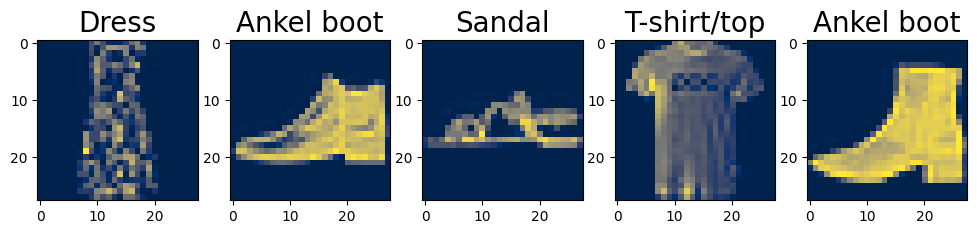

In [11]:
data_dir = './data/'

dataset = FashionMNISTDataset(data_dir)
data = dataset.get_pretrain_dataset()
classes = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankel boot']  # 총 10개의 classes

train_loader = DataLoader(
        dataset=data,
        batch_size=5,
        shuffle=True)
images, labels = next(iter(train_loader))

fig = plt.figure(figsize=(12,3))
for i, img, label in zip(range(5), images, labels):
    numpy_img = np.transpose(img.numpy(), (1, 2, 0))
    ax = fig.add_subplot(1, 5, i+1)
    ax.imshow(numpy_img)
    title = classes[int(label)]
    ax.set_title(title, fontsize=20)
plt.show()

## 3-1. AutoEncoder 네트워크 정의

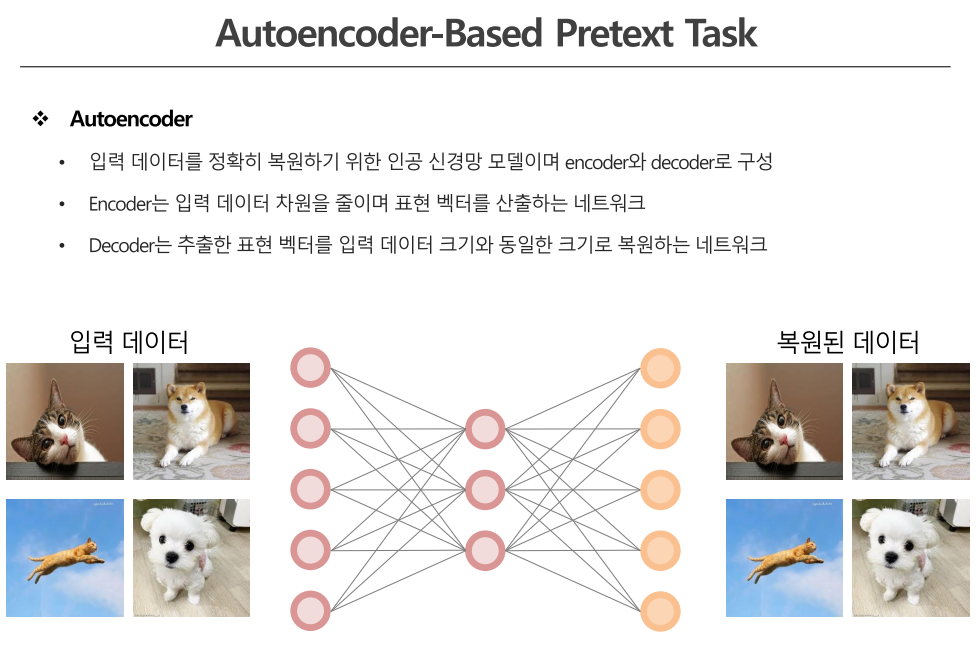

In [16]:
Image('images/5-AutoEncoder.PNG')

## 3-2. Denoising AutoEncoder 네트워크 정의

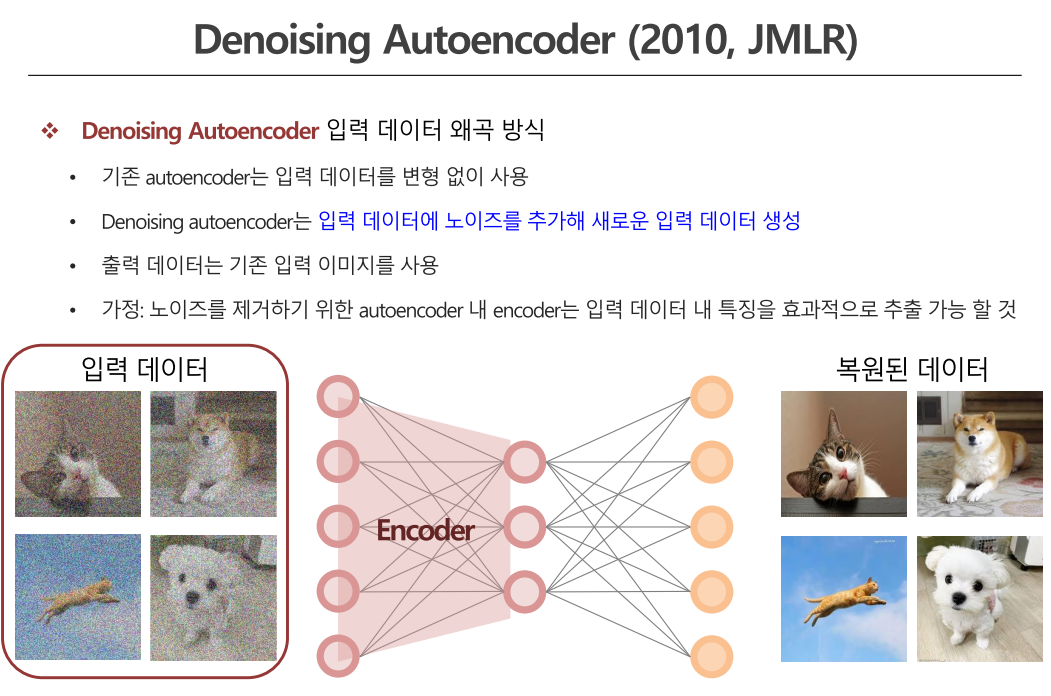

In [ ]:
Image('images/6-DenoisingAutoEncoder.PNG')

### cf. Noise가 추가된 Fashion MNIST 이미지

In [12]:
""" 원본 이미지에 Noise를 추가하는 함수 """
def add_noise(img):
    noise = torch.randn(img.size()) * 0.2  # 정규분포를 따르는 난수 생성 (무작위 추출)
    noisy_img = img + noise
    return noisy_img

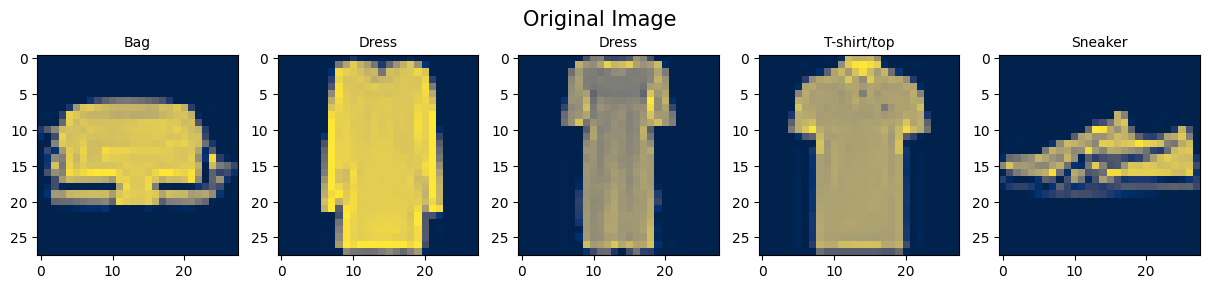

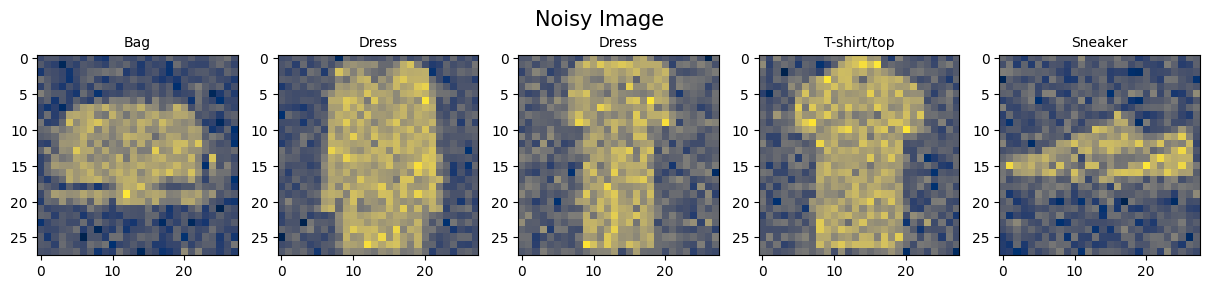

In [13]:
""" Noise가 추가된 이미지 형태 확인 """
### 경로 설정
data_dir = 'data/'

### 데이터셋 정의
dataset = FashionMNISTDataset(data_dir)
data = dataset.get_dataset()
classes = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankel boot']  # 총 10개의 classes

### Train 데이터에서 일부 데이터 불러오기
train_loader = DataLoader(
        dataset=data,
        batch_size=5,
        shuffle=True,
        num_workers=0,
        drop_last=False)
images, labels = next(iter(train_loader))

### 원본 이미지
fig = plt.figure(figsize=(15, 3))
for i, img, label in zip(range(5), images, labels):
    numpy_img = np.transpose(img.numpy(), (1, 2, 0))
    ax = fig.add_subplot(1, 5, i+1)
    ax.imshow(numpy_img)
    title = classes[int(label)]
    ax.set_title(title, fontsize=10)
plt.suptitle("Original Image", fontsize=15)
plt.show()

### Noise가 추가된 이미지
fig = plt.figure(figsize=(15, 3))
for i, img, label in zip(range(5), add_noise(images), labels):
    numpy_img = np.transpose(img.numpy(), (1, 2, 0))
    ax = fig.add_subplot(1, 5, i+1)
    ax.imshow(numpy_img)
    title = classes[int(label)]
    ax.set_title(title, fontsize=10)
plt.suptitle("Noisy Image", fontsize=15)
plt.show()

- Original Image는 일반 AutoEncoder의 input
- Noisy Image는 Denoising AutoEncoder의 input

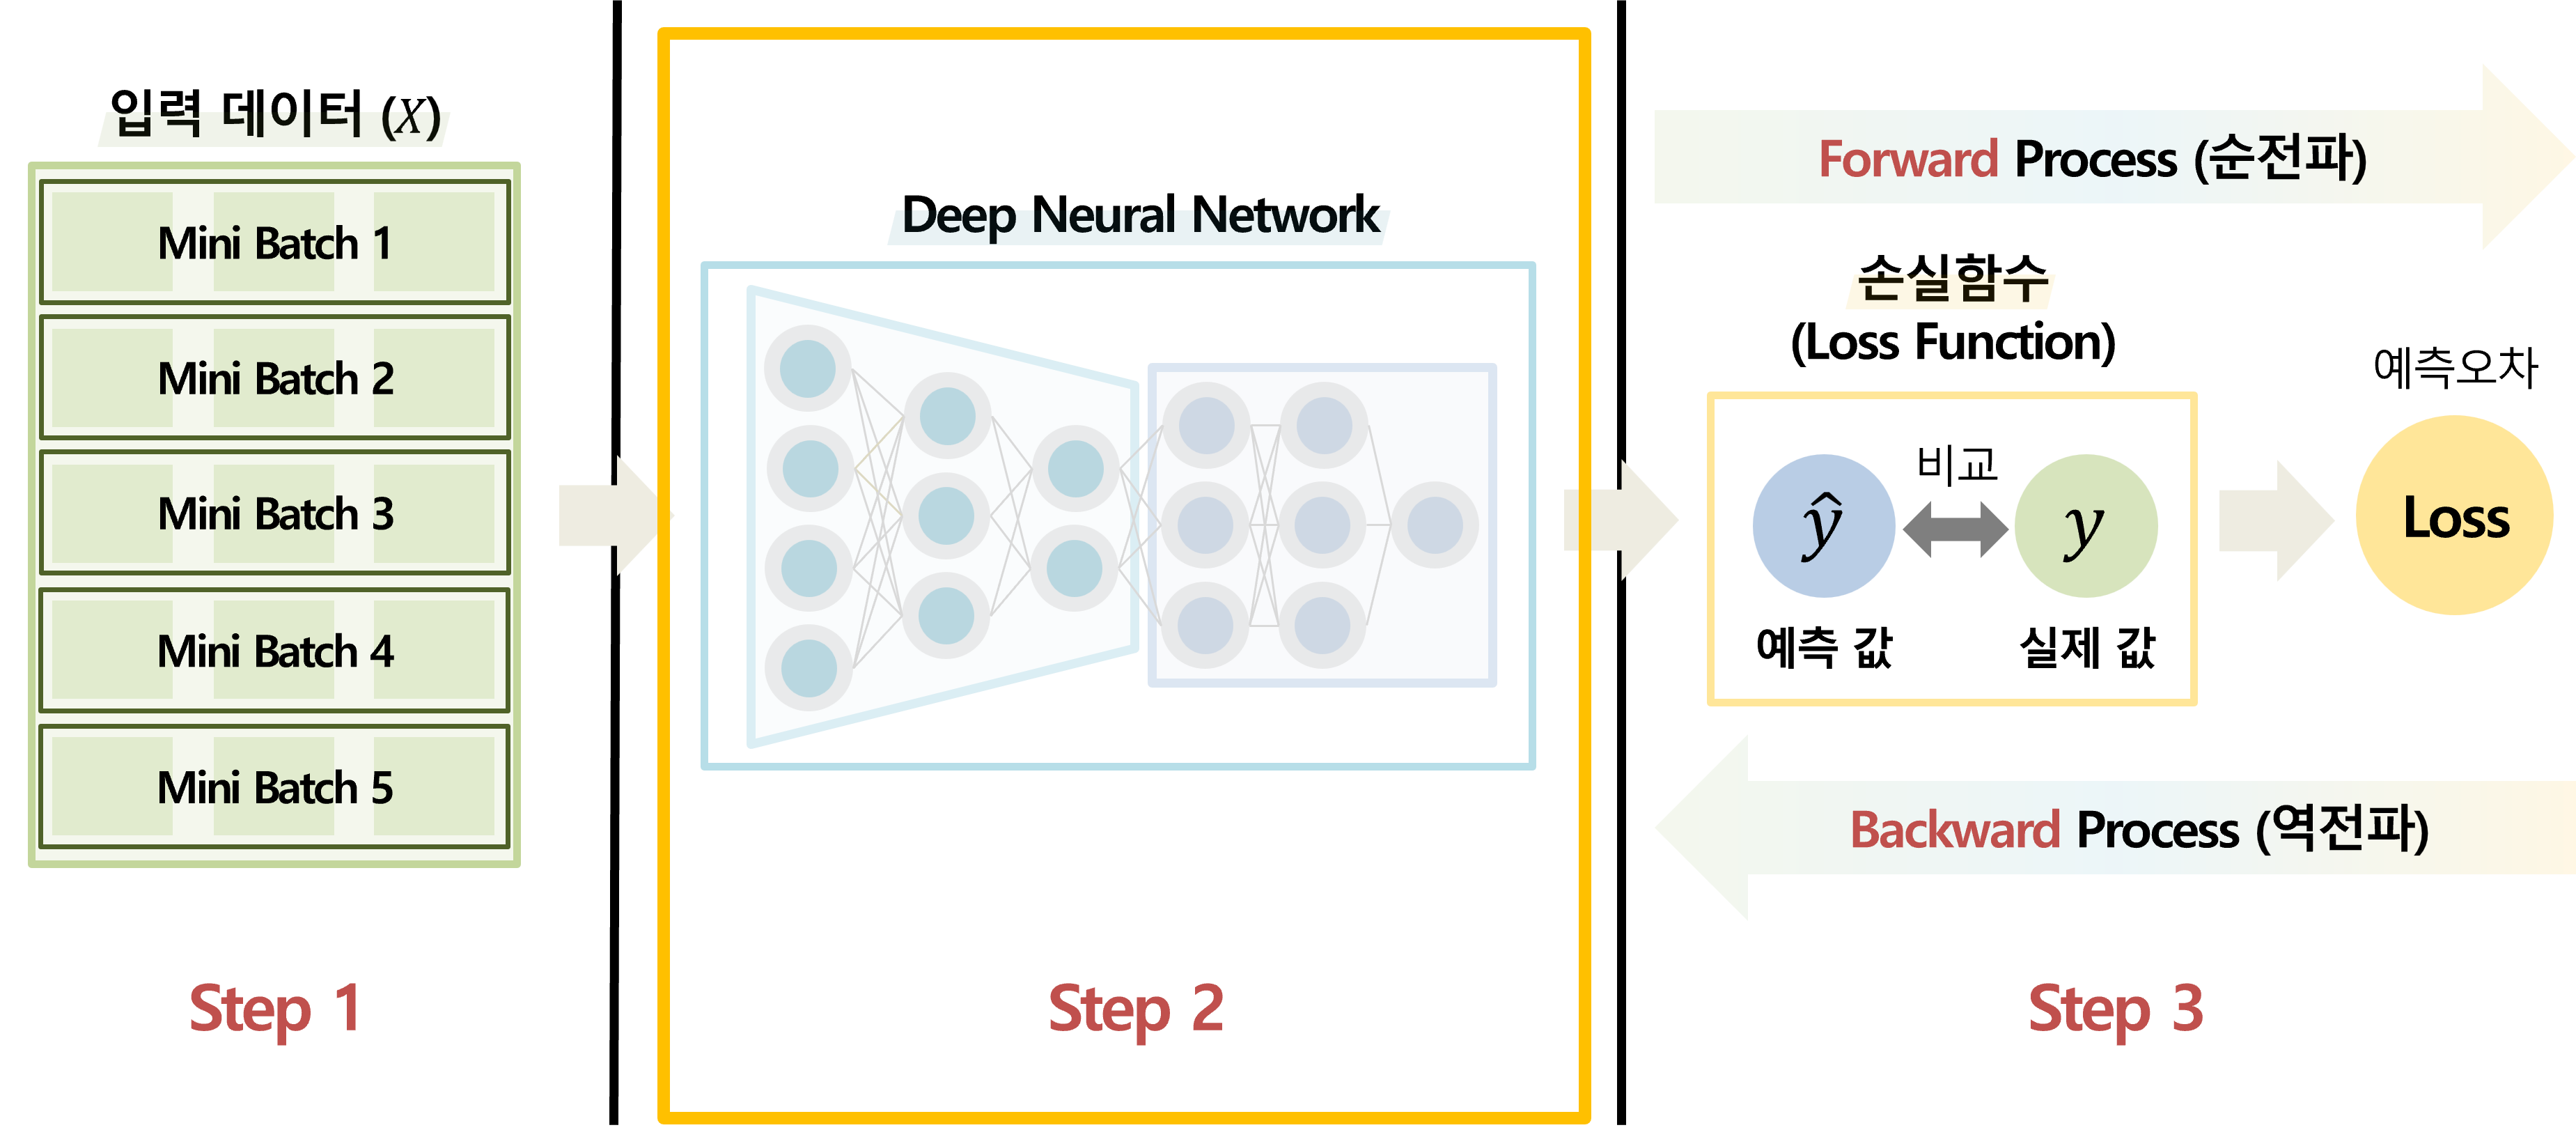

In [14]:
Image('./images/step2.png')

In [19]:
class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()

        # encoder 정의
        self.encoder = nn.Sequential(
            nn.Linear(28*28, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 12),
            nn.ReLU(),
            nn.Linear(12, 3),   # 입력의 특징을 3차원으로 압축
        )

        # decoder 정의
        self.decoder = nn.Sequential(
            nn.Linear(3, 12),
            nn.ReLU(),
            nn.Linear(12, 64),
            nn.ReLU(),
            nn.Linear(64, 128),
            nn.ReLU(),
            nn.Linear(128, 28*28), # 원본 이미지 크기로 복원
            nn.Sigmoid(),          # 픽셀당 0과 1 사이로 값을 출력
        )

    def forward(self, x):
        en_out = self.encoder(x)
        de_out = self.decoder(en_out)
        return de_out

## 4. AutoEncoder 사전학습 (Pretraining) 정의

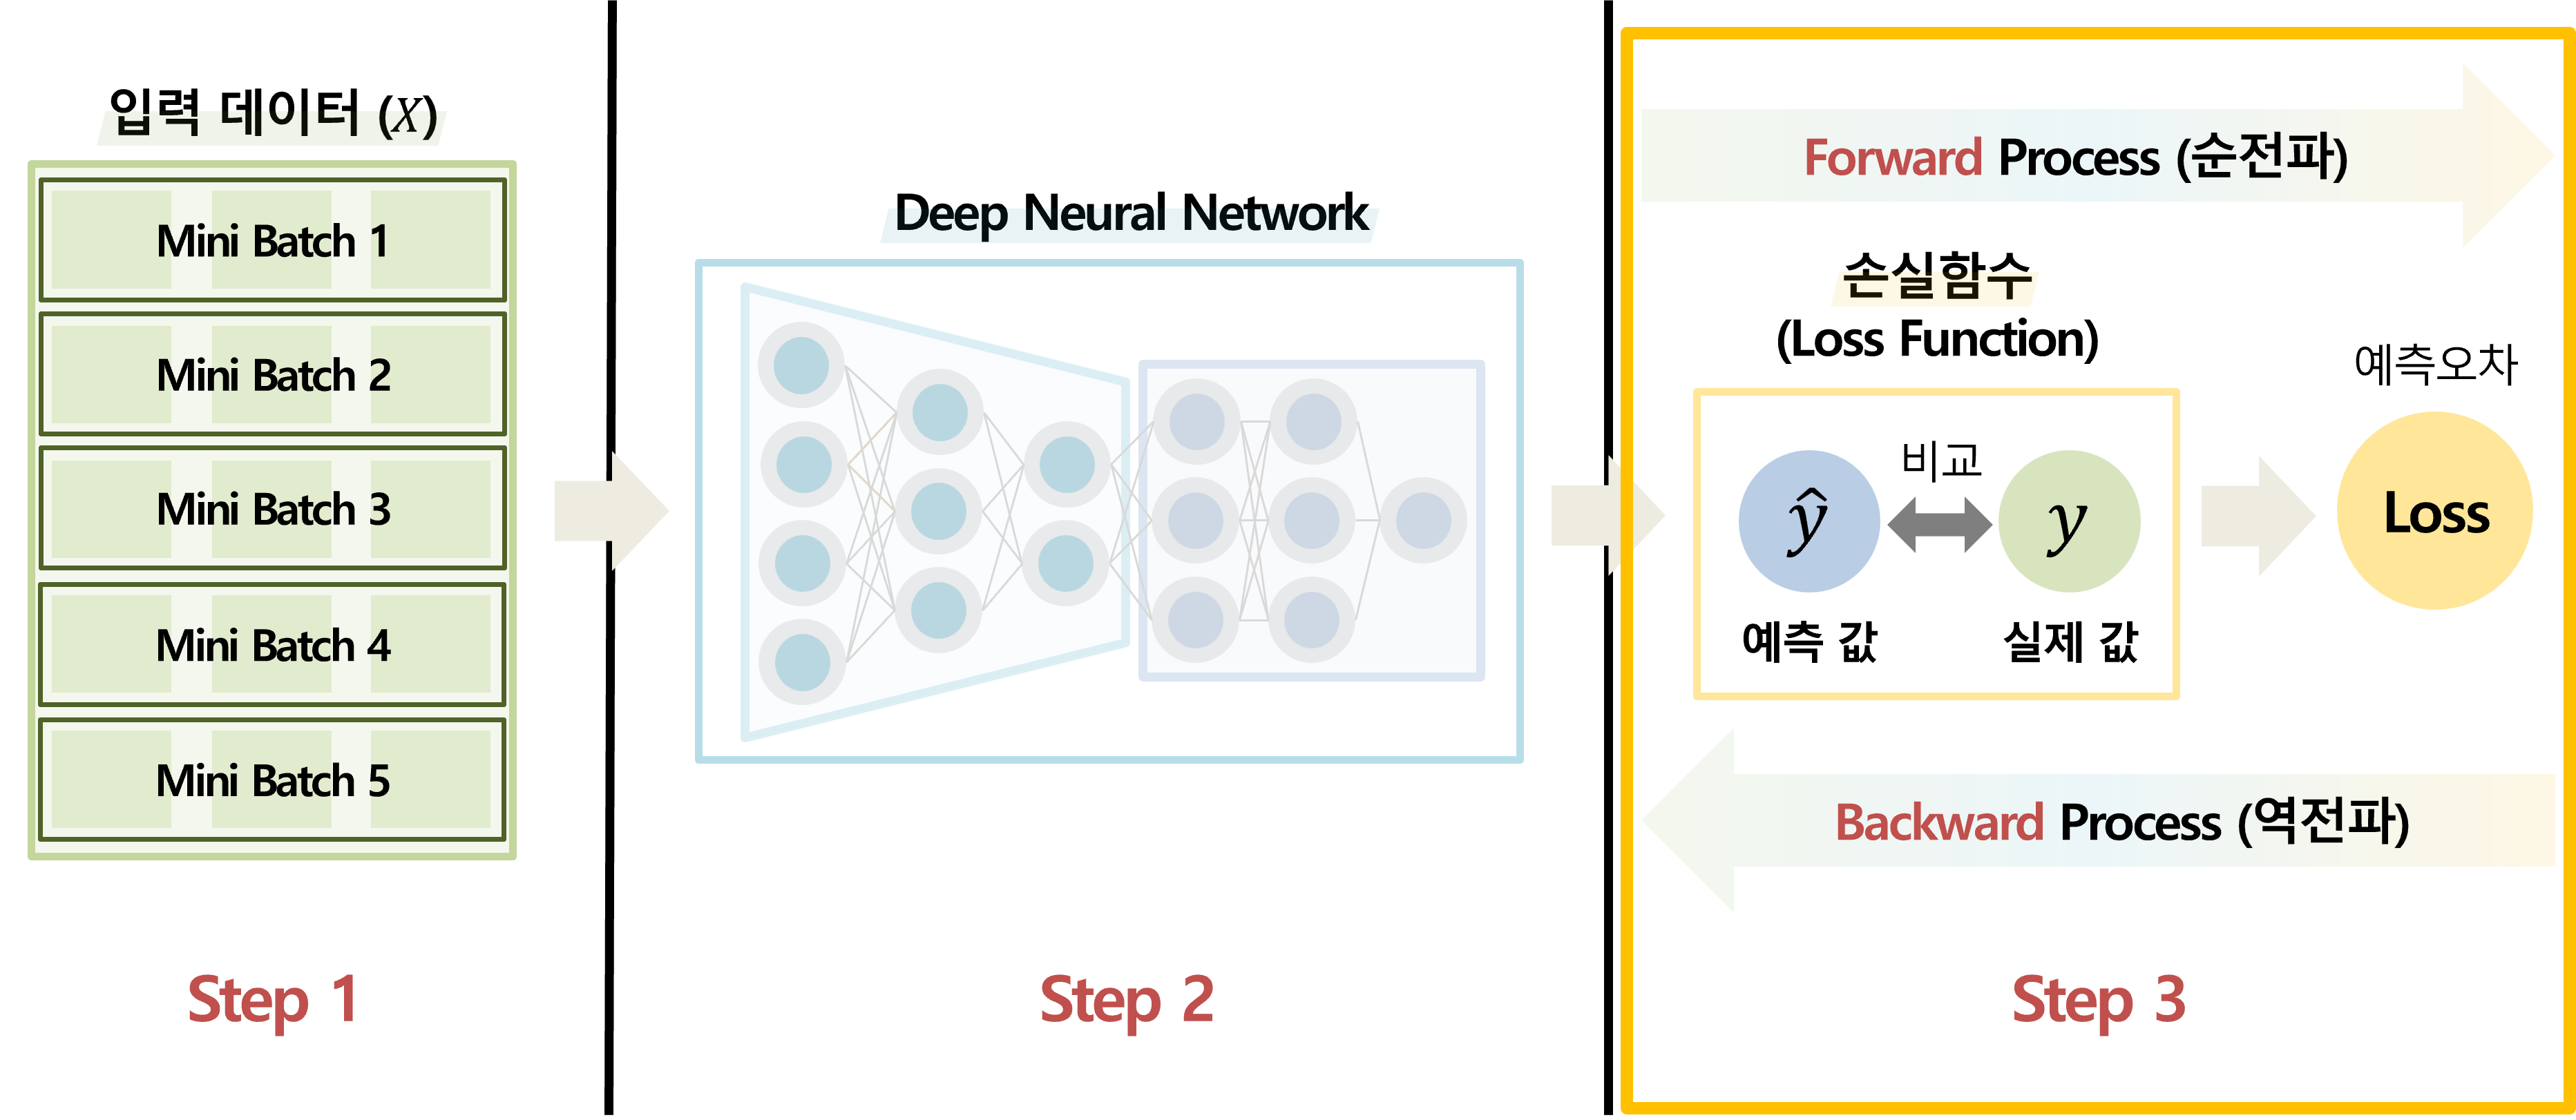

In [60]:
Image('images/step3.png')

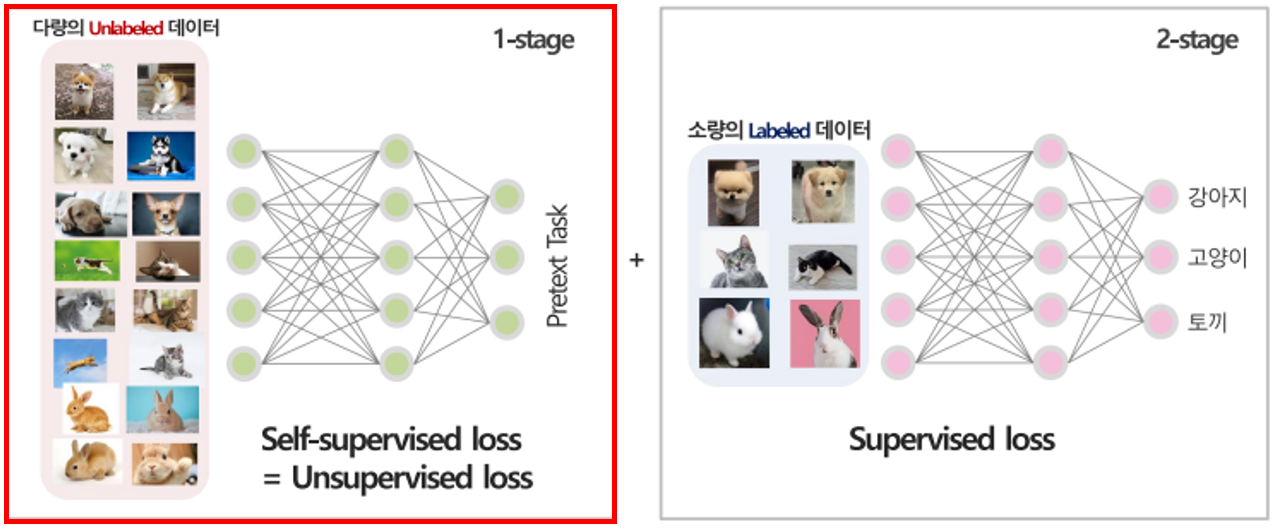

In [18]:
Image('images/2-SelfsupervisedLearning2.PNG')

In [20]:
class AE_Trainer(object):
    def __init__(self, device, model, ckpt_name:str="AE", **kwargs):
        self.device = device
        self.model = model.to(device)
        self.criterion = nn.MSELoss()  # loss - 재구축 오차
        self.ckpt_name = ckpt_name
        self.__dict__.update(kwargs)

    def pretrain(self, train_loader):
        os.makedirs(self.ckpt_dir, exist_ok=True)  # create checkpoints directory

        for epoch in range(self.epochs+1):
            running_loss, running_total = 0.0, 0
            for images, _ in train_loader:

                # images 데이터 정의 (차원을 맞춰준 후 정의한 device 상으로 데이터 올리기)
                if self.ckpt_name == "AutoEncoder":
                    images = images.view(-1, 28*28).to(self.device)
                else:
                    # AE가 아니라면 (즉, denoising AE라면) noise 추가
                    images = add_noise(images.view(-1, 28*28)).to(self.device)

                # outputs: 복원된 이미지 (encode-decode)
                outputs = self.model(images)

                # 모델 학습: 복원한 이미지와 실제 이미지의 squared loss (MSE)
                loss = self.criterion(outputs, images)

                """계산된 loss에서 gradient를 계산하는 역전파 함수: .backward()"""
                loss.backward()            # Pytorch 자동 미분
                self.optimizer.step()      # optimizer를 이용한 파라미터 업데이트
                self.optimizer.zero_grad() # Optimizer Gradient 초기화

                # iteration 단위 (batch) loss 산출
                running_loss += loss.item() * images.size(0)
                running_total += images.size(0)

            epoch_loss = running_loss / running_total
            
            # logging
            if epoch == 0 or (epoch + 1) % 5 == 0:
                print('Epoch: {} Loss: {:.4f}'.format(epoch+1, epoch_loss))
        
        # Save the model (마지막 epoch에서 모델 저장)
        torch.save(self.model.encoder.state_dict(), os.path.join(self.ckpt_dir, f'pretrained_{self.ckpt_name}_model.pt'))

        return self.model

## 5. Pretraining Task 수행

In [24]:
""" 2. Pretraining Task 학습 수행 - Autoencoder """
def main(device, configs:dict):

    # define dataset, dataloader
    dataset = FashionMNISTDataset(data_dir=configs['data_dir']) 
    train_dataset = dataset.get_pretrain_dataset()
    train_loader = DataLoader(
            dataset=train_dataset,
            batch_size=configs['batch_size'],
            shuffle=True,
            num_workers=configs['num_worker'],
            drop_last=True)
    
    # define model
    model = Autoencoder()

    # define optimizer
    optimizer = torch.optim.Adam(
        model.parameters(), 
        lr=configs['learning_rate'], 
        weight_decay=configs['weight_decay'])
    
    ### Pretraining Task 학습 알고리즘 정의
    trainer = AE_Trainer(device=device, 
                        model=model,
                        ckpt_name=configs['ckpt_dir'].split('/')[-2], # AutoEncoder
                        optimizer=optimizer,
                        batch_size = configs['batch_size'],
                        epochs = configs['epochs'],
                        ckpt_dir = configs['ckpt_dir']
                        )
    
    ### Pretraining Task 학습 수행
    pretrained_model = trainer.pretrain(train_loader=train_loader)

    return pretrained_model

### Main
if __name__ == '__main__':
    device = torch.device("cuda:0" if torch.cuda.is_available() else 'cpu')
    
    # configurations
    configs = {'data_dir': './data/',              
               'ckpt_dir': './results/AutoEncoder/',
               'batch_size': 256, 'epochs': 40, 
               'learning_rate': 5e-3, 'weight_decay':0, 'num_worker': 0}
    
    pretrained_model_ae = main(device, configs)

Epoch: 1 Loss: 0.0516
Epoch: 5 Loss: 0.0307
Epoch: 10 Loss: 0.0257
Epoch: 15 Loss: 0.0233
Epoch: 20 Loss: 0.0226
Epoch: 25 Loss: 0.0222
Epoch: 30 Loss: 0.0220
Epoch: 35 Loss: 0.0217
Epoch: 40 Loss: 0.0216


In [25]:
""" 2. Pretraining Task 학습 수행 - Denoising Autoencoder """
def main(device, configs:dict):

    # define dataset, dataloader
    dataset = FashionMNISTDataset(data_dir=configs['data_dir']) 
    train_dataset = dataset.get_pretrain_dataset()
    train_loader = DataLoader(
            dataset=train_dataset,
            batch_size=configs['batch_size'],
            shuffle=True,
            num_workers=configs['num_worker'],
            drop_last=True)
    
    # define model
    model = Autoencoder()

    # define optimizer
    optimizer = torch.optim.Adam(
        model.parameters(), 
        lr=configs['learning_rate'], 
        weight_decay=configs['weight_decay'])
    
    ### Pretraining Task 학습 알고리즘 정의
    trainer = AE_Trainer(device=device, 
                         model=model, 
                         ckpt_name=configs['ckpt_dir'].split('/')[-2], # AutoEncoder
                         optimizer=optimizer,
                         batch_size = configs['batch_size'],
                         epochs = configs['epochs'],
                         ckpt_dir = configs['ckpt_dir']
                         )

    ### Pretraining Task 학습 수행
    pretrained_model = trainer.pretrain(train_loader=train_loader)

    return pretrained_model

### Main
if __name__ == '__main__':
    device = torch.device("cuda:0" if torch.cuda.is_available() else 'cpu')
    
    # configurations
    configs = {'data_dir': './data/',              
               'ckpt_dir': './results/Denoising_AutoEncoder/',
               'batch_size': 256, 'epochs': 40, 
               'learning_rate': 5e-3, 'weight_decay':0, 'num_worker': 0}
    
    pretrained_model_denoising_ae = main(device, configs)

Epoch: 1 Loss: 0.0901
Epoch: 5 Loss: 0.0652
Epoch: 10 Loss: 0.0633
Epoch: 15 Loss: 0.0626
Epoch: 20 Loss: 0.0622
Epoch: 25 Loss: 0.0620
Epoch: 30 Loss: 0.0618
Epoch: 35 Loss: 0.0618
Epoch: 40 Loss: 0.0615


### 재구축이 잘 되었는지 확인

### 1. Testset 원본 이미지

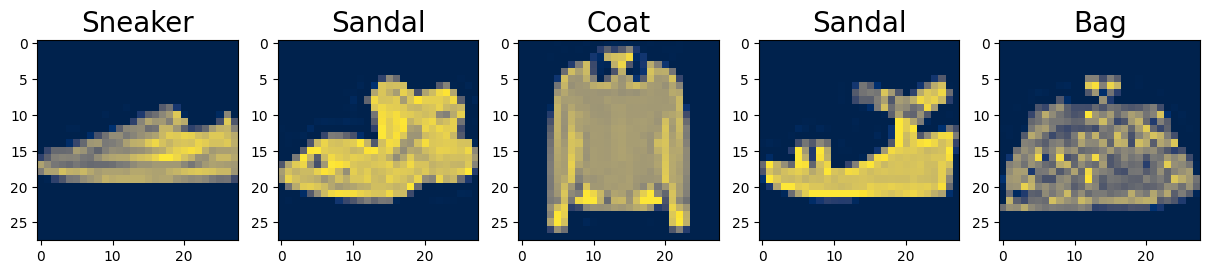

In [30]:
data_dir = configs['data_dir']

dataset = FashionMNISTDataset(data_dir)
data = dataset.get_dataset(mode='test')
classes = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankel boot']  # 총 10개의 classes

test_loader = DataLoader(
        dataset=data,
        batch_size=5,
        shuffle=False)
images, labels = next(iter(test_loader))

fig = plt.figure(figsize=(15,3))
for i, img, label in zip(range(5), images, labels):
    numpy_img = np.transpose(img.detach().numpy(), (1, 2, 0))
    ax = fig.add_subplot(1, 5, i+1)
    ax.imshow(numpy_img)
    title = classes[int(label)]
    ax.set_title(title, fontsize=20)
plt.show()

### 2-1. AutoEncoder로 복원된 Testset 이미지

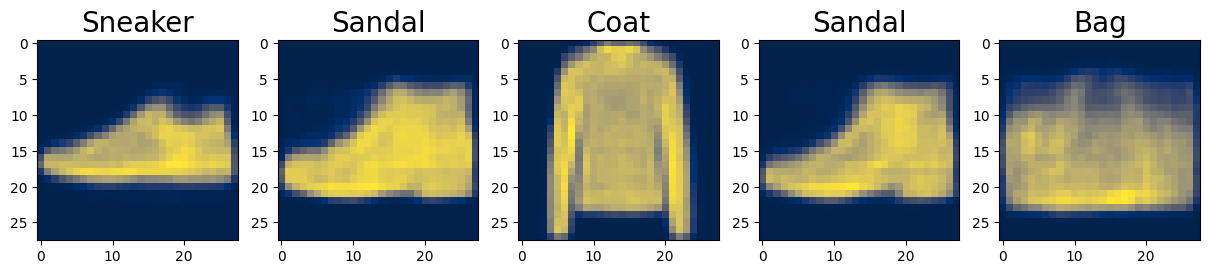

In [36]:
test_output = pretrained_model_ae(images.view(-1, 28*28).to('cuda:0')).cpu()

fig = plt.figure(figsize=(15,3))
for i, img, label in zip(range(5), test_output, labels):
    numpy_img = img.detach().numpy().reshape(28, 28, -1)
    ax = fig.add_subplot(1, 5, i+1)
    ax.imshow(numpy_img)
    title = classes[int(label)]
    ax.set_title(title, fontsize=20)
plt.show()

### 2-2. Denoising AutoEncoder로 복원된 Testset 이미지

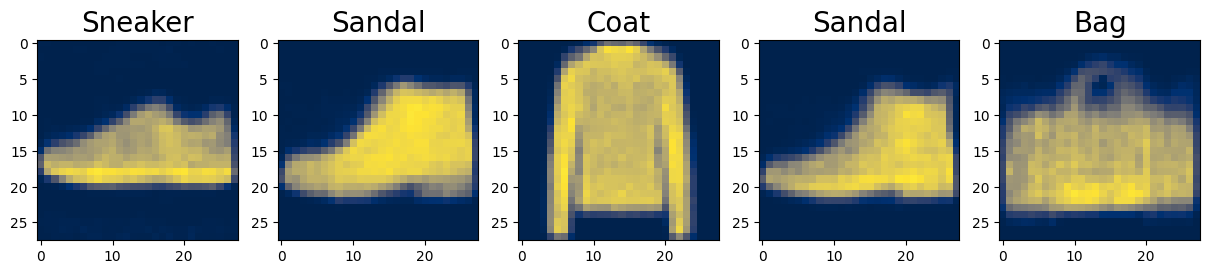

In [37]:
test_output = pretrained_model_denoising_ae(images.view(-1, 28*28).to('cuda:0')).cpu()

fig = plt.figure(figsize=(15,3))
for i, img, label in zip(range(5), test_output, labels):
    numpy_img = img.detach().numpy().reshape(28, 28, -1)
    ax = fig.add_subplot(1, 5, i+1)
    ax.imshow(numpy_img)
    title = classes[int(label)]
    ax.set_title(title, fontsize=20)
plt.show()

## 6. 사전학습 된 Encoder를 이용하여 Downstream Task 수행
- Transfer Learning(전이 학습)의 개념
- 사전학습 된 인코더를 활용하여 Supervised Learning 수행

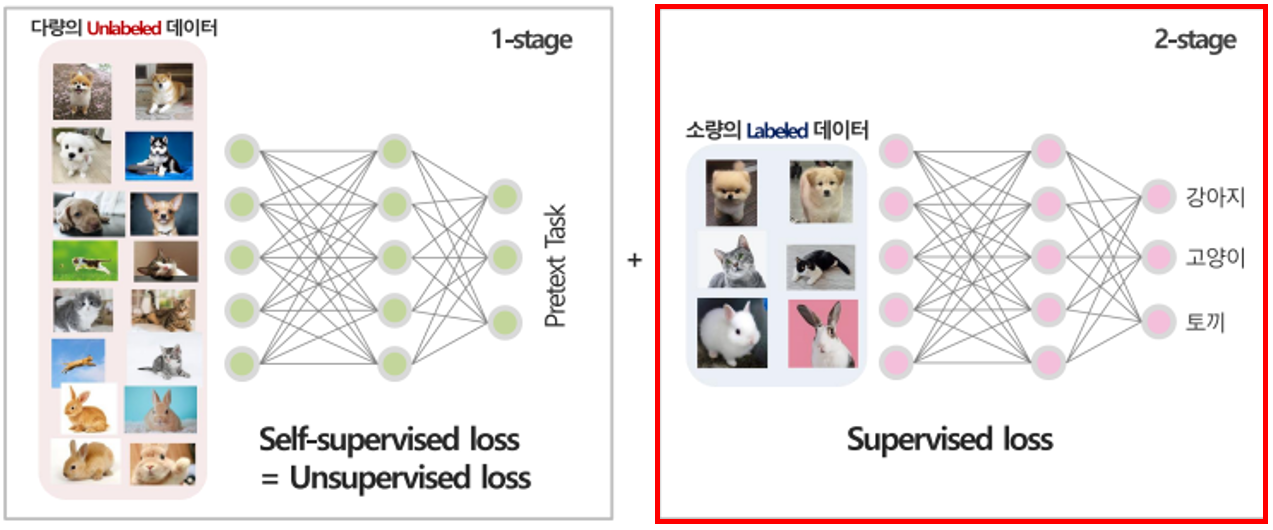

In [23]:
Image('images/2-SelfsupervisedLearning3.PNG')

In [38]:
""" 1. 평가지표 정의 - Top-k accuracy """
# 얼마나 '근접한' 예측을 하는가를 평가
# class 수가 많거나 class 구분이 미묘한 경우에 자주 사용
# top1과 topk (k>1) 간 차이가 크다면 -> 특징 추출의 품질이 낮을 가능성 (중요한 특징을 완전히 놓치지는 않았지만, 가장 중요한 특징을 인식하지 못하고 있을 수 있음)
# 애매모호한 class가 많아 class 경계가 모호할 수 있음. 모델의 불확실성이 높을 수 있음

"""
Computes the accuracy over the top k predictions for the specified values of k
Top1 Accuracy: 모델의 Top1 예측 결과가 실제 Label과 동일 --> Correct
Top5 Accuracy: 모델의 Top5 예측 결과 내에 실제 Label의 포함 --> Correct
"""

def accuracy(output: torch.FloatTensor,
             target: torch.LongTensor,
             topk: tuple=(1, )):
    
    ### max_k기준 correct 여부 판별
    with torch.no_grad():
        max_k = max(topk)  # 입력된 topk 튜플에서 최대값을 구함
        batch_size = target.size(0) 
        # output.topk()로 각 샘플에 대해 가장 높은 확률을 가진 max_k개의 클래스 인덱스 구하기
        _, pred = output.topk(k=max_k, dim=1, largest=True, sorted=True)
        pred = pred.t()  # transpose -> 각 행이 k번째 예측을 나타내게 됨

        # 예측이 정답과 일치하는지 비교
        correct = pred.eq(target.view(1, -1).expand_as(pred)) ### eq: 동일여부 판별
        # target -> one-hot encoding 없이 true class idx가 있음
        # target.view(1, -1).expand_as(pred) -> target을 pred와 같은 형태로 확장

        ### 확인하고 싶은 topk 지표들을 모두 산출 
        res = []
        for k in topk:
            # 각 k에 대해서, (1) corrct[:k]로 상위 k개의 예측 중 정답인 것을 선택
            #               (2) .reshape(-1) 으로 1차원으로 flattten
            #               (3) .float().sum(0, keepdim=True)로 정답 수를 합산
            correct_k = correct[:k].reshape(-1).float().sum(0, keepdim=True)
            res.append(correct_k.mul_(100.0 / batch_size))  # 백분율로 변환
        
        return res  # 각 k에 대한 top-k accuracy 를 포함한 리스트 반환

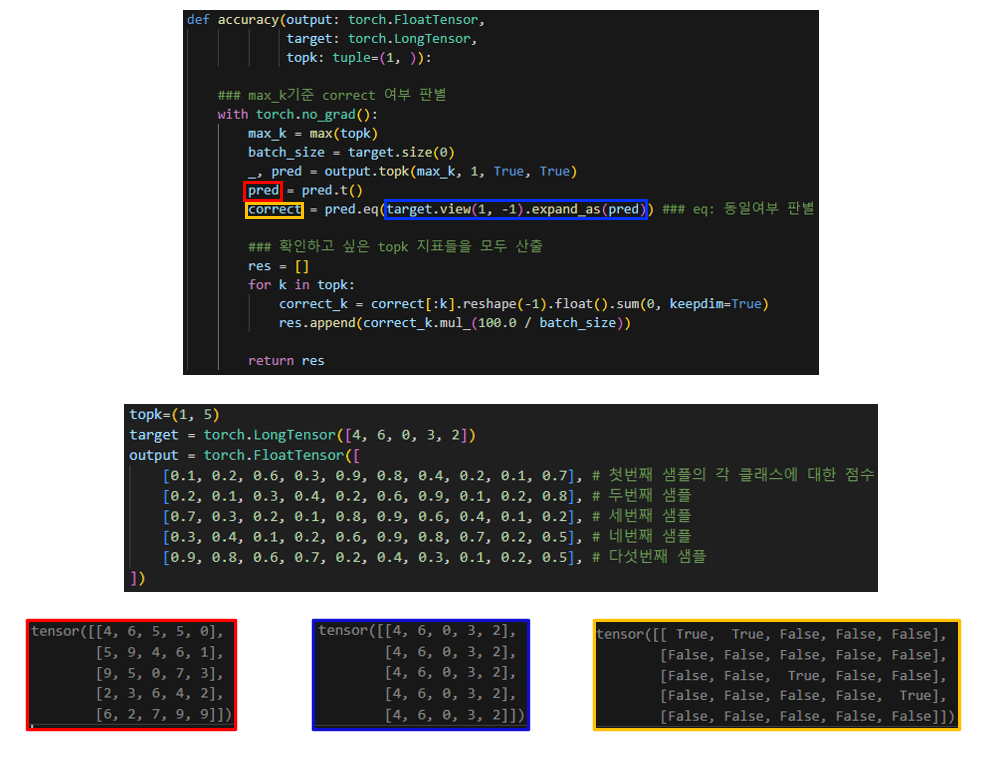

In [24]:
Image('images/14-Metric1.PNG')

In [39]:
""" 2. 미세조정 (Downstream Task) 학습 알고리즘 정의 """
class Downstream(object):

    ### 학습에 필요한 값들 초기화
    def __init__(self, device, encoder, classifier, optimizer, **kwargs):
        self.device = device
        self.encoder = encoder.to(device)
        self.classifier = classifier.to(device)
        self.optimizer = optimizer
        self.criterion = nn.CrossEntropyLoss().to(device)
        self.__dict__.update(kwargs)

    ### Downstream Task 학습 알고리즘
    def train_test(self, train_loader, test_loader):

        for epoch in range(self.epochs):

            ### train 모드
            top1_train_acc, train_loss = 0, 0
            for i, (images, targets) in enumerate(train_loader):

                ### 데이터를 Batch 단위로 불러오기
                images = images.view(-1, 28*28).to(self.device)
                targets = targets.to(self.device)
                
                ### 사전학습된 Encoder에 데이터 통과
                if self.downstream: ### Encoder Weight(사전학습된)를 학습하지 않음
                    with torch.no_grad():
                        features = self.encoder(images)
                        features = features.view(features.size(0), -1)  # flattten
                else: ### Encoder Weight를 함께 학습
                    features = self.encoder(images)
                    features = features.view(features.size(0), -1)      # flattten

                ### Classifier에 통과
                logits = self.classifier(features)
                loss = self.criterion(logits, targets)

                ### 모델 학습
                loss.backward()
                self.optimizer.step()
                self.optimizer.zero_grad()

                ### Iteration 단위(Batch) 평가 지표 산출
                top1 = accuracy(logits, targets, topk=(1, ))
                top1_train_acc += top1[0]
                
                train_loss += loss
            
            ### Epoch 단위(전체 학습데이터) 평가 지표 산출
            top1_train_acc /= (i + 1)
            train_loss /= (i + 1)

            ### Test 모드 -> 성능 logging을 위함!
            top1_test_acc, top5_test_acc = 0, 0
            for i, (images, targets) in enumerate(test_loader):

                ### 데이터를 Batch 단위로 불러오기
                images = images.view(-1, 28*28).to(self.device)
                targets = targets.to(self.device)

                ### 데이터를 모델(Encoder + Classifier)에 통과 
                with torch.no_grad():
                    features = self.encoder(images)
                    features = features.view(features.size(0), -1)  
                    logits = self.classifier(features)

                ### Iteration 단위(Batch) 평가 지표 산출
                top1, top5 = accuracy(logits, targets, topk=(1, 5))
                top1_test_acc += top1[0]
                top5_test_acc += top5[0]

            ### Epoch 단위(전체 학습데이터) 평가 지표 산출
            top1_test_acc /= (i + 1)
            top5_test_acc /= (i + 1)

            ### Log
            print(f'Epoch: {epoch + 1} \n'
                  f'Loss: {round(train_loss.item(), 4)} \n'
                  f'Top1 Train Accuracy: {round(top1_train_acc.item(), 2)} \n'
                  f'Top1 Test Accuracy: {round(top1_test_acc.item(), 2)} \n'
                  f'Top5 Test Accuracy: {round(top5_test_acc.item(), 2)} \n')
        
        return self.encoder, self.classifier

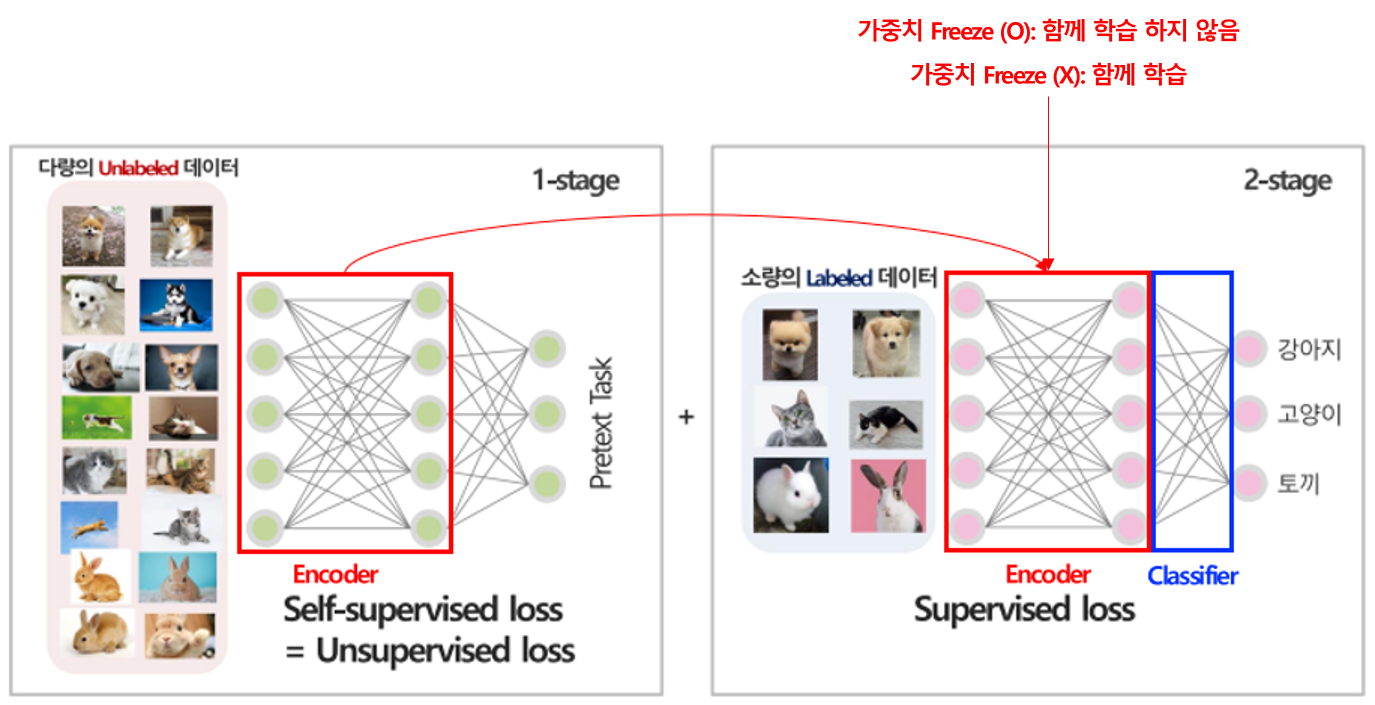

In [79]:
Image('images/2-SelfsupervisedLearning4.PNG')

In [ ]:
""" 3. 미세조정 (Downstream Task) 수행 - Encoder Freeze (O) """
def main(device, configs: dict):
    
    ### Train 및 Test 데이터셋 정의
    dataset = FashionMNISTDataset(data_dir=configs['data_dir'])   
    
    train_dataset = dataset.get_dataset(mode='train')  # downstream용 데이터셋 불러오기
    test_dataset = dataset.get_dataset(mode='test')
    
    train_loader = DataLoader(
            dataset=train_dataset,
            batch_size=configs['batch_size'],
            shuffle=True,
            num_workers=configs['num_worker'],
            drop_last=False)
    
    test_loader = DataLoader(
            dataset=test_dataset,
            batch_size=configs['batch_size'],
            shuffle=False,
            num_workers=configs['num_worker'],
            drop_last=False)
    
    ### Model Architecture 정의
    encoder = Autoencoder().encoder
    # 사전학습된 encoder의 파라미터를 불러오는 과정
    encoder.load_state_dict(torch.load(os.path.join(configs['ckpt_dir'],
                                                    f"pretrained_{configs['ckpt_dir'].split('/')[-2]}_model.pt")))
    print("All keys matched successfully")
    
    classifier = nn.Sequential(
        nn.Linear(3, 32),
        nn.ReLU(),
        nn.Linear(32, configs['num_class'])
    )

    ### Optimizer 정의
    optimizer = torch.optim.Adam(
        classifier.parameters(), 
        lr=configs['learning_rate'], 
        weight_decay=configs['weight_decay'])
    
    ### Downstream Task 학습 알고리즘 정의
    downstream = Downstream(
        device = device,
        encoder=encoder,
        classifier=classifier,
        optimizer=optimizer,
        epochs=configs['epochs'],
        downstream=configs['downstream'])
    
    ### Downstream Task 학습 수행
    supervised_encoder, supervised_classifier = downstream.train_test(train_loader=train_loader,
                                                                        test_loader=test_loader)
    
    return supervised_encoder, supervised_classifier

### Main
if __name__ == '__main__':
    device = torch.device("cuda:0" if torch.cuda.is_available() else 'cpu') 

    configs = {'data_dir': './data/', 
               'ckpt_dir': './results/AutoEncoder/', 
               'downstream': True, 'batch_size': 256, 'epochs': 10,
               'learning_rate': 1e-3, 'weight_decay':0,
               'num_class': 10, 'num_worker': 0}
    
    ae_freeze_downstream_model = main(device, configs)

All keys matched successfully
Epoch: 1 
Loss: 2.3919 
Top1 Train Accuracy: 17.76 
Top1 Test Accuracy: 25.36 
Top5 Test Accuracy: 79.42 

Epoch: 2 
Loss: 1.8507 
Top1 Train Accuracy: 36.96 
Top1 Test Accuracy: 45.44 
Top5 Test Accuracy: 94.59 

Epoch: 3 
Loss: 1.5697 
Top1 Train Accuracy: 49.58 
Top1 Test Accuracy: 55.41 
Top5 Test Accuracy: 98.12 

Epoch: 4 
Loss: 1.3812 
Top1 Train Accuracy: 59.22 
Top1 Test Accuracy: 59.41 
Top5 Test Accuracy: 98.27 

Epoch: 5 
Loss: 1.2626 
Top1 Train Accuracy: 62.24 
Top1 Test Accuracy: 62.6 
Top5 Test Accuracy: 98.22 

Epoch: 6 
Loss: 1.1823 
Top1 Train Accuracy: 63.34 
Top1 Test Accuracy: 63.24 
Top5 Test Accuracy: 98.27 

Epoch: 7 
Loss: 1.1213 
Top1 Train Accuracy: 64.83 
Top1 Test Accuracy: 64.98 
Top5 Test Accuracy: 98.41 

Epoch: 8 
Loss: 1.0792 
Top1 Train Accuracy: 65.26 
Top1 Test Accuracy: 65.04 
Top5 Test Accuracy: 98.51 

Epoch: 9 
Loss: 1.0357 
Top1 Train Accuracy: 66.72 
Top1 Test Accuracy: 64.72 
Top5 Test Accuracy: 98.61 

Epoch: 1

##### Freeze 후 downstream: (Top 1) 66.95 / (Top 5) 98.46

In [ ]:
""" 3. 미세조정 (Downstream Task) 수행 - Encoder Freeze (X) """
def main(device, configs: dict):
    
    ### Train 및 Test 데이터셋 정의
    dataset = FashionMNISTDataset(data_dir=configs['data_dir'])   
    
    train_dataset = dataset.get_dataset(mode='train')  # downstream용 데이터셋 불러오기
    test_dataset = dataset.get_dataset(mode='test')
    
    train_loader = DataLoader(
            dataset=train_dataset,
            batch_size=configs['batch_size'],
            shuffle=True,
            num_workers=configs['num_worker'],
            drop_last=False)
    
    test_loader = DataLoader(
            dataset=test_dataset,
            batch_size=configs['batch_size'],
            shuffle=False,
            num_workers=configs['num_worker'],
            drop_last=False)
    
    ### Model Architecture 정의
    encoder = Autoencoder().encoder
    encoder.load_state_dict(torch.load(os.path.join(configs['ckpt_dir'],
                                                    f"pretrained_{configs['ckpt_dir'].split('/')[-2]}_model.pt"))) ### 사전학습된 Weight 불러오기
    print("All keys matched successfully")
    
    classifier = nn.Sequential(
        nn.Linear(3, 32),
        nn.ReLU(),
        nn.Linear(32, configs['num_class'])
    )

    ### Optimizer 정의
    optimizer = torch.optim.Adam(
        classifier.parameters(), 
        lr=configs['learning_rate'], 
        weight_decay=configs['weight_decay'])
    
    ### Pretraining Task 학습 알고리즘 정의
    downstream = Downstream(
        device = device,
        encoder=encoder,
        classifier=classifier,
        optimizer=optimizer,
        epochs=configs['epochs'],
        downstream=configs['downstream'])
    
    ### Downstream Task 학습 수행
    supervised_encoder, supervised_classifier = downstream.train_test(train_loader=train_loader,
                                                                        test_loader=test_loader)
    
    return supervised_encoder, supervised_classifier

### Main
if __name__ == '__main__':
    device = torch.device("cuda:0" if torch.cuda.is_available() else 'cpu') 

    configs = {'data_dir': './data/', 
               'ckpt_dir': './results/AutoEncoder/', 
               'downstream': False, 'batch_size': 256, 'epochs': 10,
               'learning_rate': 1e-3, 'weight_decay':0,
               'num_class': 10, 'num_worker': 0}
    ae_downstream_model = main(device, configs)

All keys matched successfully
Epoch: 1 
Loss: 3.2716 
Top1 Train Accuracy: 9.12 
Top1 Test Accuracy: 13.02 
Top5 Test Accuracy: 67.75 

Epoch: 2 
Loss: 2.0125 
Top1 Train Accuracy: 30.22 
Top1 Test Accuracy: 41.17 
Top5 Test Accuracy: 82.22 

Epoch: 3 
Loss: 1.6651 
Top1 Train Accuracy: 43.84 
Top1 Test Accuracy: 45.84 
Top5 Test Accuracy: 98.1 

Epoch: 4 
Loss: 1.4826 
Top1 Train Accuracy: 49.15 
Top1 Test Accuracy: 49.11 
Top5 Test Accuracy: 98.34 

Epoch: 5 
Loss: 1.3574 
Top1 Train Accuracy: 51.6 
Top1 Test Accuracy: 52.96 
Top5 Test Accuracy: 98.31 

Epoch: 6 
Loss: 1.269 
Top1 Train Accuracy: 55.86 
Top1 Test Accuracy: 56.9 
Top5 Test Accuracy: 98.37 

Epoch: 7 
Loss: 1.2047 
Top1 Train Accuracy: 60.83 
Top1 Test Accuracy: 60.39 
Top5 Test Accuracy: 98.46 

Epoch: 8 
Loss: 1.1526 
Top1 Train Accuracy: 62.88 
Top1 Test Accuracy: 62.08 
Top5 Test Accuracy: 98.62 

Epoch: 9 
Loss: 1.1189 
Top1 Train Accuracy: 63.88 
Top1 Test Accuracy: 63.73 
Top5 Test Accuracy: 98.62 

Epoch: 10 
L

##### Freeze 없이 모두 재학습: (Top 1) 64.45 / (Top 5) 98.67

In [59]:
def main(device, configs: dict):
    
    ### Train 및 Test 데이터셋 정의
    dataset = FashionMNISTDataset(data_dir=configs['data_dir'])   
    
    train_dataset = dataset.get_dataset(mode='train')  # downstream용 데이터셋 불러오기
    test_dataset = dataset.get_dataset(mode='test')
    
    train_loader = DataLoader(
            dataset=train_dataset,
            batch_size=configs['batch_size'],
            shuffle=True,
            num_workers=configs['num_worker'],
            drop_last=False)
    
    test_loader = DataLoader(
            dataset=test_dataset,
            batch_size=configs['batch_size'],
            shuffle=False,
            num_workers=configs['num_worker'],
            drop_last=False)
    
    ### Model Architecture 정의
    encoder = Autoencoder().encoder
    # 사전학습된 encoder의 파라미터를 불러오는 과정
    encoder.load_state_dict(torch.load(os.path.join(configs['ckpt_dir'],
                                                    f"pretrained_{configs['ckpt_dir'].split('/')[-2]}_model.pt")))
    print("All keys matched successfully")
    
    classifier = nn.Sequential(
        nn.Linear(3, 32),
        nn.ReLU(),
        nn.Linear(32, configs['num_class'])
    )

    ### Optimizer 정의
    optimizer = torch.optim.Adam(
        classifier.parameters(), 
        lr=configs['learning_rate'], 
        weight_decay=configs['weight_decay'])
    
    ### Downstream Task 학습 알고리즘 정의
    downstream = Downstream(
        device = device,
        encoder=encoder,
        classifier=classifier,
        optimizer=optimizer,
        epochs=configs['epochs'],
        downstream=configs['downstream'])
    
    ### Downstream Task 학습 수행
    supervised_encoder, supervised_classifier = downstream.train_test(train_loader=train_loader,
                                                                        test_loader=test_loader)
    
    return supervised_encoder, supervised_classifier

configs = {'data_dir': './data/', 
            'ckpt_dir': './results/Denoising_AutoEncoder/', 
            'downstream': True, 'batch_size': 256, 'epochs': 10,
            'learning_rate': 1e-3, 'weight_decay':0,
            'num_class': 10, 'num_worker': 0}
d_ae_freeze_downstream_model = main(device, configs)

All keys matched successfully
Epoch: 1 
Loss: 2.13 
Top1 Train Accuracy: 29.03 
Top1 Test Accuracy: 37.6 
Top5 Test Accuracy: 88.15 

Epoch: 2 
Loss: 1.7576 
Top1 Train Accuracy: 40.11 
Top1 Test Accuracy: 44.93 
Top5 Test Accuracy: 94.67 

Epoch: 3 
Loss: 1.5058 
Top1 Train Accuracy: 49.08 
Top1 Test Accuracy: 58.52 
Top5 Test Accuracy: 97.11 

Epoch: 4 
Loss: 1.3238 
Top1 Train Accuracy: 58.26 
Top1 Test Accuracy: 60.21 
Top5 Test Accuracy: 97.33 

Epoch: 5 
Loss: 1.1999 
Top1 Train Accuracy: 59.85 
Top1 Test Accuracy: 61.47 
Top5 Test Accuracy: 97.62 

Epoch: 6 
Loss: 1.1192 
Top1 Train Accuracy: 62.06 
Top1 Test Accuracy: 63.07 
Top5 Test Accuracy: 97.82 

Epoch: 7 
Loss: 1.0601 
Top1 Train Accuracy: 64.47 
Top1 Test Accuracy: 65.93 
Top5 Test Accuracy: 97.96 

Epoch: 8 
Loss: 1.0137 
Top1 Train Accuracy: 66.16 
Top1 Test Accuracy: 66.46 
Top5 Test Accuracy: 98.21 

Epoch: 9 
Loss: 0.9791 
Top1 Train Accuracy: 66.64 
Top1 Test Accuracy: 67.09 
Top5 Test Accuracy: 98.35 

Epoch: 10 

In [57]:
def main(device, configs: dict):
    
    ### Train 및 Test 데이터셋 정의
    dataset = FashionMNISTDataset(data_dir=configs['data_dir'])   
    
    train_dataset = dataset.get_dataset(mode='train')  # downstream용 데이터셋 불러오기
    test_dataset = dataset.get_dataset(mode='test')
    
    train_loader = DataLoader(
            dataset=train_dataset,
            batch_size=configs['batch_size'],
            shuffle=True,
            num_workers=configs['num_worker'],
            drop_last=False)
    
    test_loader = DataLoader(
            dataset=test_dataset,
            batch_size=configs['batch_size'],
            shuffle=False,
            num_workers=configs['num_worker'],
            drop_last=False)
    
    ### Model Architecture 정의
    encoder = Autoencoder().encoder
    encoder.load_state_dict(torch.load(os.path.join(configs['ckpt_dir'],
                                                    f"pretrained_{configs['ckpt_dir'].split('/')[-2]}_model.pt"))) ### 사전학습된 Weight 불러오기
    print("All keys matched successfully")
    
    classifier = nn.Sequential(
        nn.Linear(3, 32),
        nn.ReLU(),
        nn.Linear(32, configs['num_class'])
    )

    ### Optimizer 정의
    optimizer = torch.optim.Adam(
        classifier.parameters(), 
        lr=configs['learning_rate'], 
        weight_decay=configs['weight_decay'])
    
    ### Pretraining Task 학습 알고리즘 정의
    downstream = Downstream(
        device = device,
        encoder=encoder,
        classifier=classifier,
        optimizer=optimizer,
        epochs=configs['epochs'],
        downstream=configs['downstream'])
    
    ### Downstream Task 학습 수행
    supervised_encoder, supervised_classifier = downstream.train_test(train_loader=train_loader,
                                                                        test_loader=test_loader)
    
    return supervised_encoder, supervised_classifier

configs = {'data_dir': './data/', 
            'ckpt_dir': './results/Denoising_AutoEncoder/', 
            'downstream': False, 'batch_size': 256, 'epochs': 10,
            'learning_rate': 1e-3, 'weight_decay':0,
            'num_class': 10, 'num_worker': 0}
d_ae_downstream_model = main(device, configs)

All keys matched successfully
Epoch: 1 
Loss: 2.3615 
Top1 Train Accuracy: 16.32 
Top1 Test Accuracy: 22.8 
Top5 Test Accuracy: 79.71 

Epoch: 2 
Loss: 1.9079 
Top1 Train Accuracy: 32.34 
Top1 Test Accuracy: 40.3 
Top5 Test Accuracy: 91.49 

Epoch: 3 
Loss: 1.6951 
Top1 Train Accuracy: 43.64 
Top1 Test Accuracy: 49.01 
Top5 Test Accuracy: 96.01 

Epoch: 4 
Loss: 1.5374 
Top1 Train Accuracy: 52.12 
Top1 Test Accuracy: 56.69 
Top5 Test Accuracy: 96.82 

Epoch: 5 
Loss: 1.3987 
Top1 Train Accuracy: 58.62 
Top1 Test Accuracy: 59.86 
Top5 Test Accuracy: 97.23 

Epoch: 6 
Loss: 1.2912 
Top1 Train Accuracy: 61.08 
Top1 Test Accuracy: 62.4 
Top5 Test Accuracy: 97.38 

Epoch: 7 
Loss: 1.2001 
Top1 Train Accuracy: 62.66 
Top1 Test Accuracy: 64.25 
Top5 Test Accuracy: 97.52 

Epoch: 8 
Loss: 1.1346 
Top1 Train Accuracy: 64.23 
Top1 Test Accuracy: 64.62 
Top5 Test Accuracy: 97.72 

Epoch: 9 
Loss: 1.0787 
Top1 Train Accuracy: 65.27 
Top1 Test Accuracy: 66.39 
Top5 Test Accuracy: 97.92 

Epoch: 10 

### Supervised Learning

In [44]:
""" 1. 비교군(지도학습) 모델 학습 """
def main(device, configs: dict):
    
    ### Train 및 Test 데이터셋 정의
    dataset = FashionMNISTDataset(data_dir=configs['data_dir']) 
    
    train_dataset = dataset.get_dataset(mode='train')
    test_dataset = dataset.get_dataset(mode='test')
    
    train_loader = DataLoader(
            dataset=train_dataset,
            batch_size=configs['batch_size'],
            shuffle=True,
            num_workers=configs['num_worker'],
            drop_last=False)
    
    test_loader = DataLoader(
            dataset=test_dataset,
            batch_size=configs['batch_size'],
            shuffle=False,
            num_workers=configs['num_worker'],
            drop_last=False)
    
    ### Model Architecture 정의
    encoder = Autoencoder().encoder   # encoder만 가져오기
    print("Supervised Learning")
    
    classifier = nn.Sequential(
        nn.Linear(3, 32),
        nn.ReLU(),
        nn.Linear(32, configs['num_class'])
    )

    ### Optimizer 정의
    optimizer = torch.optim.Adam(
        classifier.parameters(), 
        lr=configs['learning_rate'], 
        weight_decay=configs['weight_decay'])
    
    ### 지도학습 알고리즘 정의
    downstream = Downstream(
        device = device,
        encoder=encoder,
        classifier=classifier,
        optimizer=optimizer,
        epochs=configs['epochs'],
        downstream=configs['downstream'])
    
    ### 지도학습 수행
    supervised_encoder, supervised_classifier = downstream.train_test(train_loader=train_loader,
                                                                        test_loader=test_loader)
    
    return supervised_encoder, supervised_classifier

### Main
if __name__ == '__main__':
    device = torch.device("cuda:0" if torch.cuda.is_available() else 'cpu') 
    configs = {'data_dir': './data/',
               'downstream': False, 'batch_size': 256, 'epochs': 10, 
               'learning_rate': 1e-3, 'weight_decay':0,
               'num_class': 10, 'num_worker': 0}
    supervised_model = main(device, configs)

Supervised Learning
Epoch: 1 
Loss: 2.3064 
Top1 Train Accuracy: 10.05 
Top1 Test Accuracy: 9.67 
Top5 Test Accuracy: 48.46 

Epoch: 2 
Loss: 2.303 
Top1 Train Accuracy: 10.05 
Top1 Test Accuracy: 9.36 
Top5 Test Accuracy: 47.65 

Epoch: 3 
Loss: 2.3027 
Top1 Train Accuracy: 9.74 
Top1 Test Accuracy: 10.54 
Top5 Test Accuracy: 48.25 

Epoch: 4 
Loss: 2.3027 
Top1 Train Accuracy: 10.19 
Top1 Test Accuracy: 9.36 
Top5 Test Accuracy: 52.31 

Epoch: 5 
Loss: 2.3023 
Top1 Train Accuracy: 11.88 
Top1 Test Accuracy: 13.1 
Top5 Test Accuracy: 52.68 

Epoch: 6 
Loss: 2.3021 
Top1 Train Accuracy: 11.3 
Top1 Test Accuracy: 9.27 
Top5 Test Accuracy: 47.97 

Epoch: 7 
Loss: 2.302 
Top1 Train Accuracy: 8.76 
Top1 Test Accuracy: 9.42 
Top5 Test Accuracy: 50.05 

Epoch: 8 
Loss: 2.3016 
Top1 Train Accuracy: 10.63 
Top1 Test Accuracy: 16.36 
Top5 Test Accuracy: 47.73 

Epoch: 9 
Loss: 2.3016 
Top1 Train Accuracy: 10.94 
Top1 Test Accuracy: 9.27 
Top5 Test Accuracy: 50.82 

Epoch: 10 
Loss: 2.3012 
Top1

##### Supervised Learning: (Top 1) 10.01 / (Top 5) 50.64

### 성능 비교

|   | Supervised Learning | AutoEncoder (Freeze O) | **DenoisingAutoEncoder (Freeze O)** | AutoEncoder (Freeze X) | DenoisingAutoEncoder (Freeze X) |
|---| ------------------- | ---------------------- | ------------------------------- | ---------------------- | ------------------------------- |
|Top 1 Test ACC| 10.10 | 66.95 | 64.45 | **68.07** | 67.47 |
|Top 5 Test ACC| 50.64 | 98.46 | 98.67 | **98.65** | 98.01 |

#### 질문: Encoder를 언제 재학습(fine-tuning) 해야 하는가?
- Downstream Task용 데이터셋의 개수가 충분할 때 (모델을 다시 학습시킬 수 있을 만큼 labeled data가 충분할 때)
- Pretraining용 데이터셋과 Downstream용 데이터셋 사이에 Domain gap (데이터셋 간의 분포 차이)가 클 때

##### 질문: Encoder를 부분적으로만 학습시킬 수는 없을까?
- Downstream Task를 수행할 때는 (1) 전체 fine-tuning, (2) 부분 fine-tuning, (3) Linear probing, (4) 점진적 unfreezing 등의 여러가지 방식을 택할 수 있음  

    1. 전체 fine-tuning
        - encoder와 downtream task를 위한 새 layers를 모두 재학습
        - labeled dataset이 충분하고 pretraining 용 데이터셋과 downstream 용 데이터셋 간의 차이가 있을 때
        
    2. 부분 fine-tuning
        - encoder의 상위 몇 개 layers는 재학습, 나머지 하위 layers는 freeze (파라미터 업데이트를 하지 않음)
        - labeled dataset이 상대적으로 부족하고 pretraining 용 데이터셋과 downstream 용 데이터셋 간의 차이가 별로 없을 때

    3. Linear probing
        - encoder를 완전히 freeze 하고, 새로운 layer (주로 linear classifier/regressor)만 재학습
        - downstream task용 데이터셋이 제한적이고 pretraining 용 데이터셋과 downstream 용 데이터셋이 매우 유사할 떄
        - 과적합 위험이 가장 낮음

    4. 점진적 unfreezing
        - 처음에는 encoder를 freeze 하고 linear classifier/regressor만 학습하다가, 학습이 진행됨에 따라 점진적으로 encoder의 상위 층부터 unfreezing
        - labeled dataset이 어느 정도 있고, 최적의 성능과 안정성을 동시에 추구할 때

- 즉, downstream용 labeled dataset이 작을 수록 더 많은 파라미터를 freeze 함 (과적합 방지 위함). 더불어 pretraining 용 데이터셋과 downstream 용 데이터셋 간의 domain gap이 적을 수록 (데이터셋이 유사할 수록) 더 많은 파라미터를 freeze 하는 것이 좋음.